# YOLOv8 Model Adaptation for Medical X-Ray Detection

This notebook focuses on adapting the YOLOv8 architecture for the specialized task of detecting medical findings in chest X-rays. We'll analyze the base architecture, implement modifications specific to medical imaging, and prepare the model for training.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from ultralytics import YOLO

plt.style.use('fivethirtyeight')
sns.set_context('notebook')

## Setup and Configuration

First, let's set up our project paths and configuration. We'll import the dataset information and configuration from our preprocessing stage to inform our model adaptations.

In [3]:
project_root = Path('../')
data_dir = project_root / 'data'
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed' / 'yolo_dataset'
configs_dir = project_root / 'configs'

os.makedirs(configs_dir, exist_ok=True)

data_yaml_path = processed_data_dir / 'data.yaml'
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Dataset Configuration:")
for key, value in data_config.items():
    print(f"  {key}: {value}")

Dataset Configuration:
  names: ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
  nc: 14
  train: ./train/images
  val: ./val/images


## YOLOv8 Architecture Analysis

Before making adaptations, let's understand the base YOLOv8 architecture. YOLOv8 builds upon previous YOLO versions with several improvements, including:

1. A more efficient backbone 
2. A neck featuring Path Aggregation Network (PAN) for multi-scale feature fusion
3. Decoupled detection heads
4. Anchor-free detection
5. Multiple task heads (detection, segmentation, classification)

For our medical finding detection task, we'll focus on the detection capabilities while adapting for grayscale medical imagery.

In [4]:
base_model = YOLO('yolov8n.pt') 

print(f"\nYOLOv8 Base Model Summary:")
base_model.info()

model_task = base_model.task
model_stride = base_model.stride
model_names = base_model.names

print(f"\nTask: {model_task}")
print(f"Stride: {model_stride}")
print(f"Default classes: {len(model_names)}")


YOLOv8 Base Model Summary:
YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs

Task: detect
Stride: tensor([ 8., 16., 32.])
Default classes: 80


## Medical Imaging Adaptation Requirements

Chest X-ray images and their findings have specific characteristics that require adaptations to the standard YOLO architecture:

1. **Grayscale Input**: X-rays are single-channel grayscale images, unlike the 3-channel RGB images YOLO was designed for
2. **Subtle Features**: Medical findings often have subtle visual signatures with low contrast
3. **Variable Sizes**: Findings range from very small (nodules) to large areas (pneumothorax)
4. **Class Imbalance**: Some conditions are much rarer than others
5. **High Sensitivity Requirement**: In medical contexts, false negatives are more costly than false positives

Let's analyze our dataset statistics to inform these adaptations.

In [5]:
train_labels_dir = processed_data_dir / 'train' / 'labels'
train_images_dir = processed_data_dir / 'train' / 'images'

image_dimensions = {}
for img_path in train_images_dir.glob('*.png'):
    img_id = img_path.stem  
    img = plt.imread(img_path)
    image_dimensions[img_id] = img.shape[:2]  # (height, width)

heights = [h for h, w in image_dimensions.values()]
widths = [w for h, w in image_dimensions.values()]

print(f"Found {len(image_dimensions)} images")
print(f"Height range: {min(heights)} to {max(heights)} pixels")
print(f"Width range: {min(widths)} to {max(widths)} pixels")

if len(set(heights)) == 1 and len(set(widths)) == 1:
    print("All images have consistent dimensions")
    img_height, img_width = heights[0], widths[0]
else:
    print(f"Images have varying dimensions: {len(set(heights))} different heights, {len(set(widths))} different widths")
    img_height, img_width = int(np.median(heights)), int(np.median(widths))
    print(f"Using median dimensions for analysis: {img_width}x{img_height}")


widths = []
heights = []
aspect_ratios = []
areas = []
labels = []


for label_file in train_labels_dir.glob('*.txt'):
    img_id = label_file.stem
    if img_id not in image_dimensions:
        continue
        
    img_height, img_width = image_dimensions[img_id]
    
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:  # class_id, x_center, y_center, width, height
                class_id = int(parts[0])
                # YOLO format is normalized, convert back to pixels using correct dimensions
                w = float(parts[3]) * img_width
                h = float(parts[4]) * img_height
                
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w / h)
                areas.append(w * h)
                labels.append(class_id)


widths = np.array(widths)
heights = np.array(heights)
aspect_ratios = np.array(aspect_ratios)
areas = np.array(areas)
labels = np.array(labels)

print(f"Analyzed {len(widths)} bounding boxes across {len(set(labels))} classes")

Found 400 images
Height range: 1904 to 3408 pixels
Width range: 1728 to 3320 pixels
Images have varying dimensions: 161 different heights, 177 different widths
Using median dimensions for analysis: 2483x2880
Analyzed 4356 bounding boxes across 14 classes


### Handling High-Resolution Medical Images

The analysis reveals that our dataset contains very high-resolution images (median 2483×2880 pixels) with significant variation in dimensions. This is typical for medical imaging but presents challenges for object detection models:

1. YOLOv8 typically processes images at much lower resolutions (640×640 pixels)
2. Processing at full resolution would require excessive memory
3. Downscaling too aggressively could lose critical small findings
4. Varying dimensions require a consistent processing strategy

Let's address these challenges in our model adaptation approach.

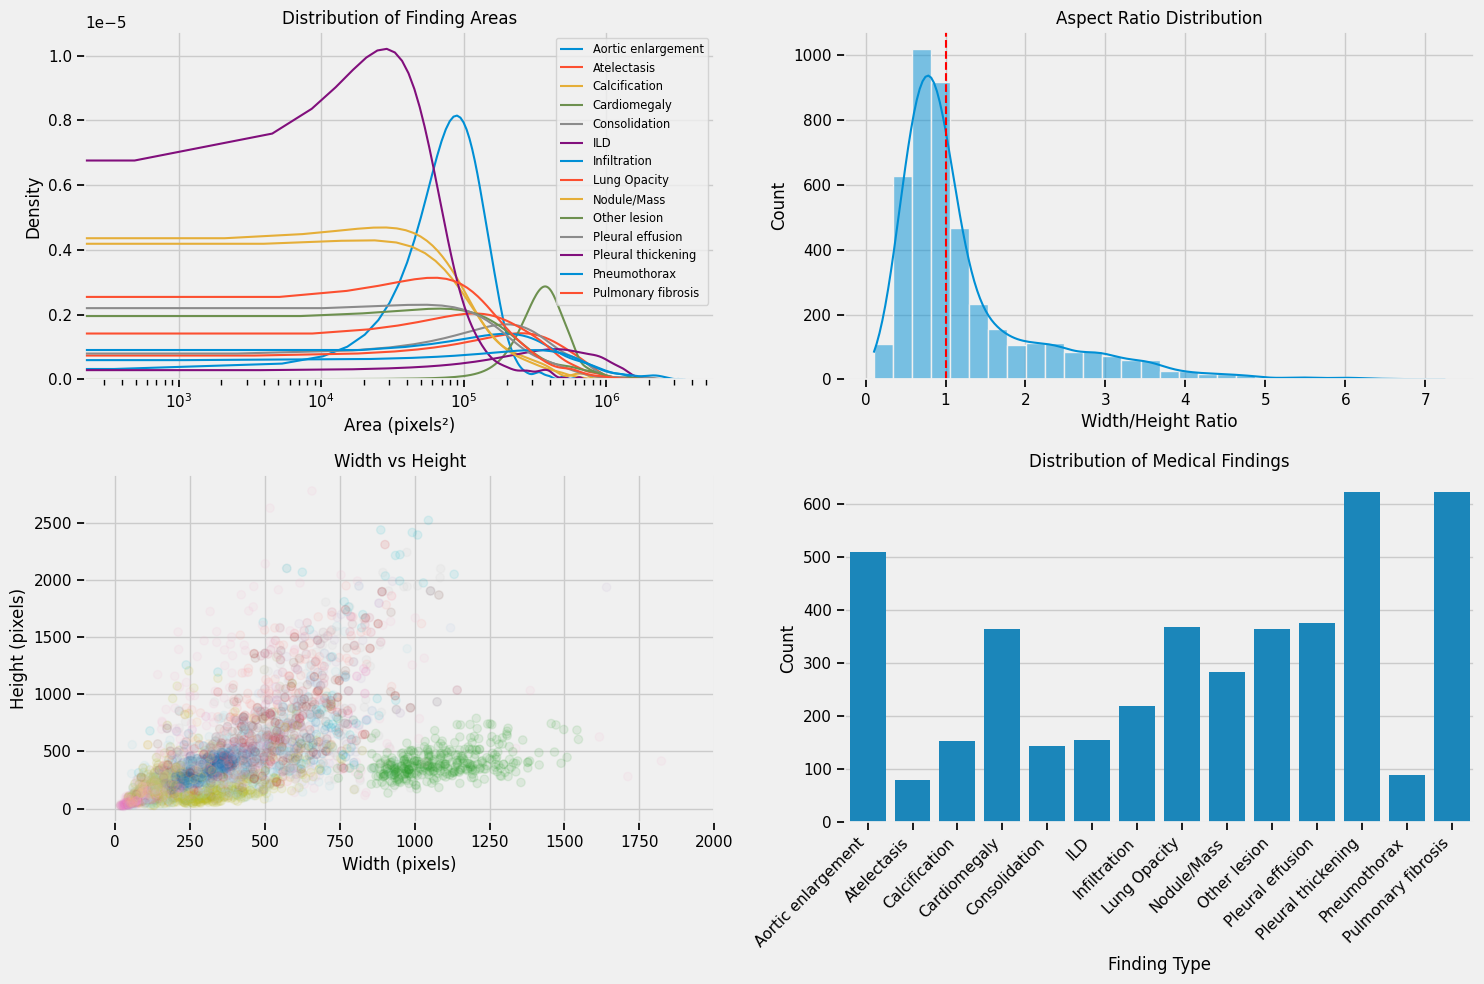


Bounding Box Statistics:
Mean width: 422.3 pixels (min: 17.0, max: 1824.0)
Mean height: 442.9 pixels (min: 18.0, max: 2777.0)
Mean area: 242208.5 pixels² (min: 357.0, max: 3175337.8)
Mean aspect ratio: 1.25

Object Size Distribution:
Small objects (<32×32 pixels): 0.3%
Medium objects (32×32 to 96×96 pixels): 6.6%
Large objects (>96×96 pixels): 93.1%


In [6]:
# Plot size distributions with our high-resolution context
plt.figure(figsize=(15, 10))

# Plot 1: Area distribution by class
plt.subplot(2, 2, 1)
for class_id in range(14):
    class_mask = labels == class_id
    if np.any(class_mask):
        class_areas = areas[class_mask]
        sns.kdeplot(class_areas, label=data_config['names'][class_id])
plt.title('Distribution of Finding Areas')
plt.xlabel('Area (pixels²)')
plt.ylabel('Density')
plt.xscale('log')
plt.legend(fontsize='x-small')

# Plot 2: Aspect ratio distribution
plt.subplot(2, 2, 2)
sns.histplot(aspect_ratios, bins=30, kde=True)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Width/Height Ratio')
plt.ylabel('Count')
plt.axvline(1, color='red', linestyle='--')  # Line at square aspect ratio

# Plot 3: Width vs Height scatter
plt.subplot(2, 2, 3)
plt.scatter(widths, heights, alpha=0.1, c=labels, cmap='tab20')
plt.title('Width vs Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.xlim(-100, 2000)

# Plot 4: Class distribution
plt.subplot(2, 2, 4)
class_counts = pd.Series(labels).value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
ax.set_xticks(range(len(data_config['names'])))
ax.set_xticklabels([name for name in data_config['names']], rotation=45, ha='right')
plt.title('Distribution of Medical Findings')
plt.xlabel('Finding Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nBounding Box Statistics:")
print(f"Mean width: {widths.mean():.1f} pixels (min: {widths.min():.1f}, max: {widths.max():.1f})")
print(f"Mean height: {heights.mean():.1f} pixels (min: {heights.min():.1f}, max: {heights.max():.1f})")
print(f"Mean area: {areas.mean():.1f} pixels² (min: {areas.min():.1f}, max: {areas.max():.1f})")
print(f"Mean aspect ratio: {aspect_ratios.mean():.2f}")

# Calculate proportion of small objects
small_threshold = 32 * 32  # Objects smaller than 32×32 pixels are challenging
medium_threshold = 96 * 96  # Objects between 32×32 and 96×96 are medium
small_objects = np.sum(areas < small_threshold) / len(areas) * 100
medium_objects = np.sum((areas >= small_threshold) & (areas < medium_threshold)) / len(areas) * 100
large_objects = np.sum(areas >= medium_threshold) / len(areas) * 100

print(f"\nObject Size Distribution:")
print(f"Small objects (<32×32 pixels): {small_objects:.1f}%")
print(f"Medium objects (32×32 to 96×96 pixels): {medium_objects:.1f}%")
print(f"Large objects (>96×96 pixels): {large_objects:.1f}%")

### Size Distribution Analysis

The visualization and statistics reveal several key characteristics of our medical findings:

- **Size Distribution**: 93.1% of findings are large (>96×96 pixels), with only 0.3% small objects (<32×32 pixels)
- **Aspect Ratios**: Most findings have aspect ratios near 1.0 (square), with a tail toward wider objects
- **Class Balance**: "Pleural thickening" and "Pulmonary fibrosis" are most common, while "Pneumothorax" and "Atelectasis" are relatively rare
- **Spatial Patterns**: The scatter plot shows two distinct clusters of findings, suggesting anatomical region specificity

These insights support our adaptation strategy:
1. Input resolution of 1024×1024 pixels will adequately preserve the details of findings
2. The anchor-free detection approach of YOLOv8 aligns well with the varied aspect ratios
3. Class weighting is essential to handle the imbalance between finding types

In [7]:
median_original_dimensions = (2483, 2880)
target_resolutions = [
    (640, 640),  
    (1024, 1024),  
    (1280, 1280), 
]

small_width = np.percentile(widths, 5)
small_height = np.percentile(heights, 5)
small_area = small_width * small_height

print(f"Original median image dimensions: {median_original_dimensions[0]}×{median_original_dimensions[1]} pixels")
print(f"5th percentile finding dimensions: {small_width:.1f}×{small_height:.1f} pixels, area: {small_area:.1f} pixels²")

for target_width, target_height in target_resolutions:
    # Calculate preservation factors
    width_factor = target_width / median_original_dimensions[0]
    height_factor = target_height / median_original_dimensions[1]
    scale_factor = min(width_factor, height_factor)
    
    # Calculate new dimensions
    new_small_width = small_width * scale_factor
    new_small_height = small_height * scale_factor
    new_small_area = new_small_width * new_small_height
    
    print(f"\nTarget resolution: {target_width}×{target_height}")
    print(f"Scale factor: {scale_factor:.3f}")
    print(f"Small finding becomes: {new_small_width:.1f}×{new_small_height:.1f} pixels, area: {new_small_area:.1f} pixels²")
    

    if new_small_width < 3 or new_small_height < 3:
        feasibility = "VERY POOR - Too small to detect"
    elif new_small_width < 8 or new_small_height < 8:
        feasibility = "POOR - Smaller than smallest stride"
    elif new_small_width < 16 or new_small_height < 16:
        feasibility = "MODERATE - Detectable with stride-8 features"
    else:
        feasibility = "GOOD - Well represented in model features"
        
    print(f"Detection feasibility: {feasibility}")

Original median image dimensions: 2483×2880 pixels
5th percentile finding dimensions: 74.0×71.0 pixels, area: 5254.0 pixels²

Target resolution: 640×640
Scale factor: 0.222
Small finding becomes: 16.4×15.8 pixels, area: 259.5 pixels²
Detection feasibility: MODERATE - Detectable with stride-8 features

Target resolution: 1024×1024
Scale factor: 0.356
Small finding becomes: 26.3×25.2 pixels, area: 664.2 pixels²
Detection feasibility: GOOD - Well represented in model features

Target resolution: 1280×1280
Scale factor: 0.444
Small finding becomes: 32.9×31.6 pixels, area: 1037.8 pixels²
Detection feasibility: GOOD - Well represented in model features


### Resolution Selection for Model Training

After analyzing the impact of different resolutions on small findings, we've determined that 1024×1024 provides the optimal balance:

- Small findings (5th percentile) remain well represented at 26×25 pixels
- Detection feasibility is rated as "GOOD" for this resolution
- Balances detail preservation with computational efficiency

We'll proceed with 1024×1024 as our input resolution for model adaptation and training.

In [8]:
def adapt_model_for_medical_imaging( base_model_size='n', num_classes=14, input_resolution=(1024, 1024)):
    """
    Create and adapt a YOLOv8 model for medical X-ray image analysis
    """
    model = YOLO(f'yolov8{base_model_size}.pt')
    
    # Create a custom YAML configuration
    custom_config = {
        'task': 'detect',
        'nc': num_classes,  
        'names': data_config['names'], 
        'imgsz': input_resolution,  
        'single_cls': False,  
    }
    
    # Save custom model config
    custom_yaml_path = configs_dir / 'medical_xray_model.yaml'
    os.makedirs(configs_dir, exist_ok=True)
    
    with open(custom_yaml_path, 'w') as f:
        yaml.dump(custom_config, f)
    
    print(f"Created adapted model configuration for {num_classes} classes")
    print(f"Input resolution: {input_resolution}")
    print(f"Classes: {data_config['names']}")
    print(f"Config saved to: {custom_yaml_path}")
    
    return custom_yaml_path, model

# Create our adapted model with the optimal resolution
model_yaml_path, base_model = adapt_model_for_medical_imaging(
    base_model_size='n',  
    num_classes=14,       
    input_resolution=(1024, 1024)
)

Created adapted model configuration for 14 classes
Input resolution: (1024, 1024)
Classes: ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
Config saved to: ..\configs\medical_xray_model.yaml


## Class Weighting Strategy

To address the class imbalance in our dataset, we'll implement a weighted loss function. This ensures the model pays appropriate attention to rarer findings like pneumothorax and atelectasis.

In [9]:
# Calculate class weights based on inverse frequency
class_counts = pd.Series(labels).value_counts().sort_index()
total_boxes = len(labels)
class_weights = {}

for i in range(14):
    if i in class_counts.index:
        count = class_counts[i]
        weight = total_boxes / (14 * count)
        # Cap weights to avoid extreme values
        class_weights[i] = min(weight, 10.0)
    else:
        class_weights[i] = 1.0

def create_weighted_config(class_weights, output_path):
    """
    Create a weighted loss configuration for YOLOv8 training
    """
    # Format weights for YAML
    weights_line = ', '.join([f"{class_weights.get(i, 1.0):.3f}" for i in range(14)])
    
    # Create custom hyper.yaml for weighted loss
    hyper_content = f"""
# YOLOv8 Hyperparameters for Medical X-Ray Detection
task: detect
# Loss weights (cls, box, dfl)
cls_loss_weight: 0.5  # class loss gain
box_loss_weight: 7.5  # box loss gain
dfl_loss_weight: 1.5  # dfl loss gain
# Class weights for balanced training
class_weights: [{weights_line}]  # class weights
    """
    
    with open(output_path, 'w') as f:
        f.write(hyper_content)
    
    print(f"Created weighted loss configuration at {output_path}")
    
    return output_path


print("Class weights to address imbalance:")
for i in range(14):
    class_name = data_config['names'][i]
    weight = class_weights.get(i, 1.0)
    count = class_counts.get(i, 0)
    print(f"- {class_name}: weight={weight:.2f} ({count} instances)")


hyper_path = configs_dir / 'medical_hyper.yaml'
weighted_config_path = create_weighted_config(class_weights, hyper_path)

Class weights to address imbalance:
- Aortic enlargement: weight=0.61 (510 instances)
- Atelectasis: weight=3.94 (79 instances)
- Calcification: weight=2.02 (154 instances)
- Cardiomegaly: weight=0.85 (364 instances)
- Consolidation: weight=2.16 (144 instances)
- ILD: weight=2.01 (155 instances)
- Infiltration: weight=1.41 (220 instances)
- Lung Opacity: weight=0.85 (368 instances)
- Nodule/Mass: weight=1.10 (284 instances)
- Other lesion: weight=0.85 (365 instances)
- Pleural effusion: weight=0.83 (377 instances)
- Pleural thickening: weight=0.50 (624 instances)
- Pneumothorax: weight=3.50 (89 instances)
- Pulmonary fibrosis: weight=0.50 (623 instances)
Created weighted loss configuration at ..\configs\medical_hyper.yaml


## Medical-Specific Data Augmentation

X-ray images require specialized augmentation strategies that preserve diagnostic features. We'll define augmentations that mimic realistic variations in patient positioning and imaging conditions.

In [10]:
def create_augmentation_config(output_path):
    """
    Create an augmentation configuration specific to medical X-rays
    """
    aug_content = """
# YOLOv8 Augmentation Configuration for Medical X-Rays

# Mosaic and mixup
mosaic: 0.0  # Disabled as it may create unrealistic combinations
mixup: 0.0   # Disabled for the same reason

# HSV color augmentation
hsv_h: 0.0   # No hue for grayscale
hsv_s: 0.0   # No saturation for grayscale
hsv_v: 0.1   # Small brightness adjustments (contrast)

# Geometric transformations
degrees: 5.0          # Small rotation to simulate patient positioning
translate: 0.1        # Small translation
scale: 0.2            # Scale to simulate different distances
shear: 2.0            # Small shear to simulate projection variations
perspective: 0.0      # No perspective as X-rays are parallel projections
flip_ud: 0.0          # No vertical flip (preserves anatomical orientation)
flip_lr: 0.1          # Occasional horizontal flip (anatomically plausible)

# Other augmentations
copy_paste: 0.0       # Disabled as it creates unrealistic combinations
auto_augment: none    # No auto augment
    """
    
    with open(output_path, 'w') as f:
        f.write(aug_content)
    
    print(f"Created medical augmentation configuration at {output_path}")
    return output_path


aug_path = configs_dir / 'medical_augmentation.yaml'
aug_config_path = create_augmentation_config(aug_path)

Created medical augmentation configuration at ..\configs\medical_augmentation.yaml


## Training Configuration

Now, we combine all our adaptations into a complete training configuration.

In [11]:
def create_training_config(output_path):
    """
    Create a comprehensive training configuration for medical X-ray detection
    """
    dataset_path = 'data/processed/yolo_dataset/data.yaml'
    
    hyper_path = 'configs/medical_hyper.yaml'
    aug_path = 'configs/medical_augmentation.yaml'
    
    train_content = f"""
# YOLOv8 Training Configuration for Medical X-Ray Detection

# Dataset
data: {dataset_path}  # Path to dataset configuration

# Model parameters
model: yolov8n.pt     # Base model to start from
epochs: 100           # Number of epochs
patience: 20          # Early stopping patience
batch: 16             # Batch size
imgsz: 1024           # Input resolution
device:               # Auto-select device

# Hyperparameters 
hyp: {hyper_path}     # Custom hyperparameters with weighted loss

# Augmentation
augment: True         # Use augmentation
aug_config: {aug_path}  # Medical-specific augmentation config

# Validation
val: True             # Validate during training
save: True            # Save results
save_period: 10       # Save checkpoint every 10 epochs

# Performance optimization
workers: 8            # Number of worker threads
optimizer: AdamW      # Optimizer
lr0: 0.001            # Initial learning rate
lrf: 0.01             # Final learning rate ratio (lr0 * lrf)
momentum: 0.937       # SGD momentum/Adam beta1
weight_decay: 0.0005  # Optimizer weight decay
warmup_epochs: 3      # Warmup epochs
warmup_momentum: 0.8  # Warmup initial momentum
warmup_bias_lr: 0.1   # Warmup initial bias lr
    """
    
    with open(output_path, 'w') as f:
        f.write(train_content)
    
    print(f"Created comprehensive training configuration at {output_path}")
    return output_path


train_config_path = configs_dir / 'train_config.yaml'
training_config_path = create_training_config(train_config_path)

Created comprehensive training configuration at ..\configs\train_config.yaml


# Summary and Next Steps

In this notebook, we've successfully adapted the YOLOv8 architecture for the specialized task of detecting medical findings in chest X-rays:

1. **Dataset Analysis**
2. **Model Adaptation**
3. **Class Weighting Strategy**
4. **Augmentation Strategy**
5. **Training Configuration**

In the next notebook, we will leverage these adaptations to train a model with high sensitivity for detecting the 14 types of medical findings in chest X-rays.